In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("SpotifyFeatures.csv")

In [4]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [6]:
df.isnull().sum()

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [7]:
#dropping track name column as we cannot include it for the prediction
df.drop(['track_name', 'track_id'], axis=1, inplace=True)

In [8]:
# Creating artist average popularity
artist_avg_pop = df.groupby('artist_name')['popularity'].mean()
df['artist_avg_popularity'] = df['artist_name'].map(artist_avg_pop)

In [9]:
# Creating genre average popularity
genre_avg_pop = df.groupby('genre')['popularity'].mean()
df['genre_avg_popularity'] = df['genre'].map(genre_avg_pop)

In [10]:
# Create feature interactions by combing the columns
df['danceability_per_loudness'] = df['danceability'] / (df['loudness'] + 1e-5)
df['energy_valence'] = df['energy'] * df['valence']
df['duration_mins'] = df['duration_ms'] / 60000

In [23]:
# Engineered features
df['acoustic_energy_diff'] = df['energy'] - df['acousticness']
df['tempo_valence'] = df['tempo'] * df['valence']
df['speech_energy'] = df['speechiness'] * df['energy']
df['log_tempo'] = np.log1p(df['tempo'])
df['log_duration'] = np.log1p(df['duration_mins'])
df['danceability_per_loudness'] = df['danceability'] / (df['loudness'] + 1e-5)
df['energy_valence'] = df['energy'] * df['valence']

In [11]:
# Drop raw categorical features now replaced
df.drop(['artist_name', 'genre', 'duration_ms'], axis=1, inplace=True)

In [24]:
df.head()

,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,artist_avg_popularity,genre_avg_popularity,danceability_per_loudness,energy_valence,duration_mins,acoustic_energy_diff,tempo_valence,speech_energy,log_tempo,log_duration
0,0,0.611,0.389,0.910,0.000,4,0.3460,-1.828,0,0.0525,...,4.651899,12.174097,-0.212802,0.740740,1.656217,0.299,135.912766,0.047775,5.123779,0.976903
1,1,0.246,0.590,0.737,0.000,9,0.1510,-5.559,1,0.0868,...,3.000000,12.174097,-0.106134,0.601392,2.289550,0.491,141.986448,0.063972,5.164803,1.190751
2,3,0.952,0.663,0.131,0.000,3,0.1030,-13.879,1,0.0362,...,9.076923,12.174097,-0.047770,0.048208,2.837783,-0.821,36.611584,0.004742,4.610038,1.344895
3,0,0.703,0.240,0.326,0.000,4,0.0985,-12.178,0,0.0395,...,4.651899,12.174097,-0.019708,0.074002,2.540450,-0.377,38.989066,0.012877,5.151892,1.264254
4,4,0.950,0.331,0.225,0.123,8,0.2020,-21.150,0,0.0456,...,8.700000,12.174097,-0.015650,0.087750,1.377083,-0.725,54.824640,0.010260,4.952837,0.865874


In [13]:
# Encode remaining categorical features
for col in ['key', 'mode', 'time_signature']:
    df[col] = LabelEncoder().fit_transform(df[col])

In [32]:
df.head()

,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,artist_avg_popularity,genre_avg_popularity,danceability_per_loudness,energy_valence,duration_mins,acoustic_energy_diff,tempo_valence,speech_energy,log_tempo,log_duration
0,0,0.611,0.389,0.910,0.000,4,0.3460,-1.828,0,0.0525,...,4.651899,12.174097,-0.212802,0.740740,1.656217,0.299,135.912766,0.047775,5.123779,0.976903
1,1,0.246,0.590,0.737,0.000,9,0.1510,-5.559,1,0.0868,...,3.000000,12.174097,-0.106134,0.601392,2.289550,0.491,141.986448,0.063972,5.164803,1.190751
2,3,0.952,0.663,0.131,0.000,3,0.1030,-13.879,1,0.0362,...,9.076923,12.174097,-0.047770,0.048208,2.837783,-0.821,36.611584,0.004742,4.610038,1.344895
3,0,0.703,0.240,0.326,0.000,4,0.0985,-12.178,0,0.0395,...,4.651899,12.174097,-0.019708,0.074002,2.540450,-0.377,38.989066,0.012877,5.151892,1.264254
4,4,0.950,0.331,0.225,0.123,8,0.2020,-21.150,0,0.0456,...,8.700000,12.174097,-0.015650,0.087750,1.377083,-0.725,54.824640,0.010260,4.952837,0.865874


In [25]:
# Drop rows with any missing values (precautionary)
df.dropna(inplace=True)

In [26]:
X = df.drop('popularity', axis=1)
y = df['popularity']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

In [30]:
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R² Score: 0.8231
RMSE: 58.91


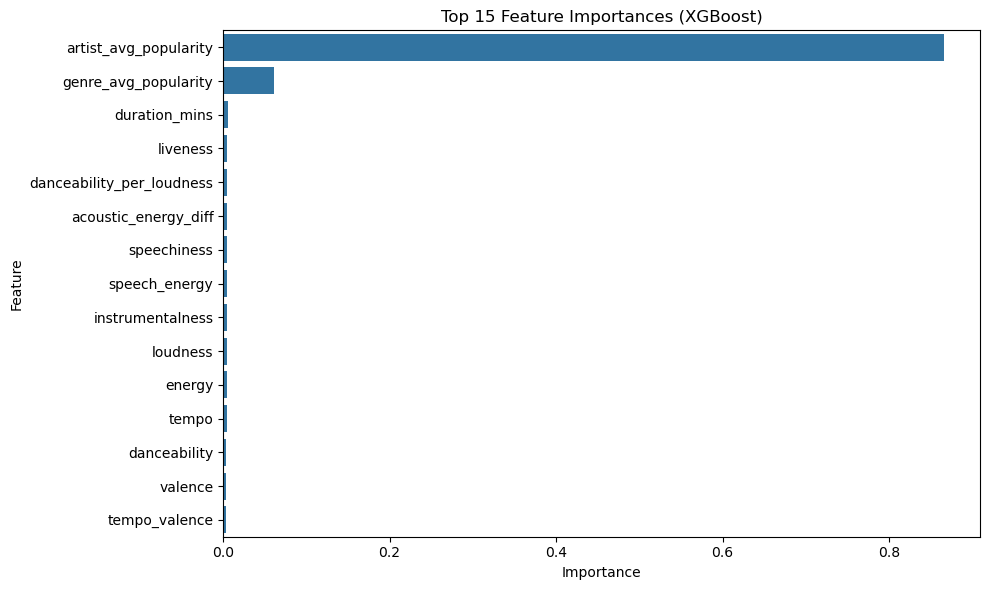

In [31]:
# Feature importance
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()